# Exploratory data analysis

**confirm working directory**

In [13]:
import os
current_working_directory = os.getcwd()
print(current_working_directory)

/Users/andrewruiz/HPAM9000_ruiz/Python


## Calculate minimum infection rate (MIR)

MIR is a measure of the amount of virus that is ciruclating in the environment. It is calculated as the (numberof positive pools/the total number of mosquitoes tested)*1000. it is commonly used as  measure to indicate transmission risk

In [24]:
import pandas as pd

# Load the dataset
df_wnv = pd.read_csv('../data/processed_data/wnv_cleaned.csv')

# Convert TEST DATE to datetime and create a 'Year-Week' column in 'YYYY-WW' format
df_wnv['TEST DATE'] = pd.to_datetime(df_wnv['TEST DATE'])
df_wnv['Year'] = df_wnv['TEST DATE'].dt.year
df_wnv['Week'] = df_wnv['TEST DATE'].dt.isocalendar().week
df_wnv['Year-Week'] = df_wnv['Year'].astype(str) + '-' + df_wnv['Week'].apply(lambda x: f'{x:02d}')

# Create a column to indicate positive results
df_wnv['positive'] = (df_wnv['RESULT'] == 'positive').astype(int)

# Group by 'Year-Week' and calculate the necessary sums for MIR calculation
weekly_summaries = df_wnv.groupby('Year-Week').agg(
    Positive_Pools=('positive', 'sum'),
    Total_Mosquitoes=('NUMBER OF MOSQUITOES', 'sum')
).reset_index()

# Calculate MIR
weekly_summaries['MIR'] = (weekly_summaries['Positive_Pools'] / weekly_summaries['Total_Mosquitoes'])*1000

# Ensure there's no division by zero
weekly_summaries['MIR'] = weekly_summaries['MIR'].fillna(0)

# Save the resulting DataFrame
weekly_summaries.to_csv('../data/processed_data/wnv_mir1.csv', index=False)



/var/folders/98/yljxdbwn1zl6kzb6gbpk54xh0000gn/T/ipykernel_42713/2040789984.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_wnv['TEST DATE'] = pd.to_datetime(df_wnv['TEST DATE'])


In [34]:
import pandas as pd

# Assuming df_wnv_mir is your DataFrame with the MIR data in the notebook

# Step 1: Read the weather data from wx_weeknum.csv
df_wx_weeknum = pd.read_csv('../data/processed_data/wx_weeknum.csv')
df_mir1 = pd.read_csv('../data/processed_data/wnv_mir1.csv')

# Step 2: Merge the MIR DataFrame with the weather data DataFrame on 'Year-Week'
# Make sure the 'Year-Week' column is correctly named in both DataFrames
# If the actual column name is different, adjust 'Year-Week' in the on parameter of pd.merge accordingly
merged_df = pd.merge(df_mir, df_wx_weeknum, on='Year-Week', how='inner')

# Step 3: Save the merged DataFrame to a new CSV file, if necessary
merged_df.to_csv('../data/processed_data/wnv_wx_merged.csv', index=False)



In [28]:
print(df_mir.head())  # This will help you confirm that MIR values are correctly calculated and not all zeros.

  Year-Week  Positive_Pools  Total_Mosquitoes  MIR
0   2007-22               0                39  0.0
1   2007-23               0               112  0.0
2   2007-26               0               294  0.0
3   2007-27               0               239  0.0
4   2007-28               0              1088  0.0


In [39]:
df_mir1['Year-Week'] = df_mir1['Year-Week'].astype(str)  # Ensuring 'Year-Week' is string
df_wx_weeknum['Year-Week'] = df_wx_weeknum['Year-Week'].astype(str)  # Ensuring 'Year-Week' is string

# Attempt the merge again
merged_df = pd.merge(df_mir1, df_wx_weeknum, on='Year-Week', how='inner')
merged_df.to_csv('../data/processed_data/wnv_wx_merged.csv', index=False)

## We know that temperature and precipitaton can affect mosquito development. It can also affect how quickly a virus can be transmitted by a mosquito.

### we will take a look at the relationship between the three variables. 

The first plot is the average temperature by week number and year against the MIR values. 

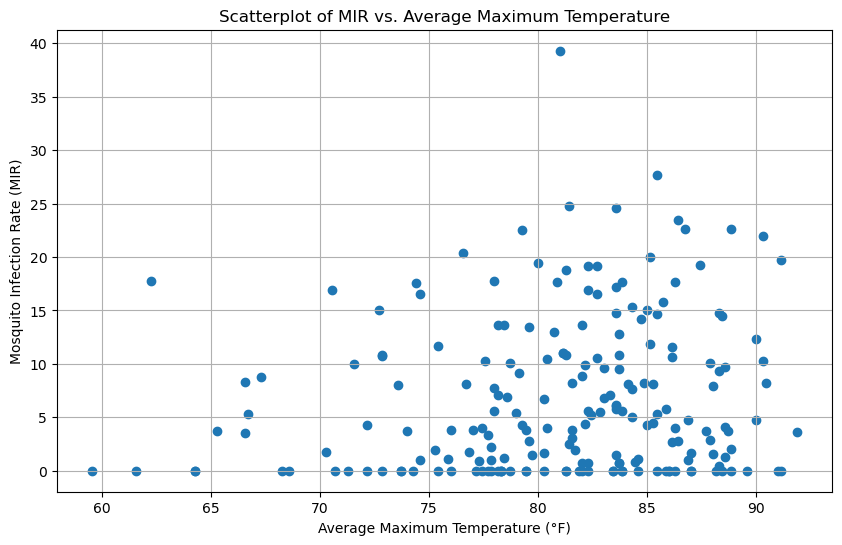

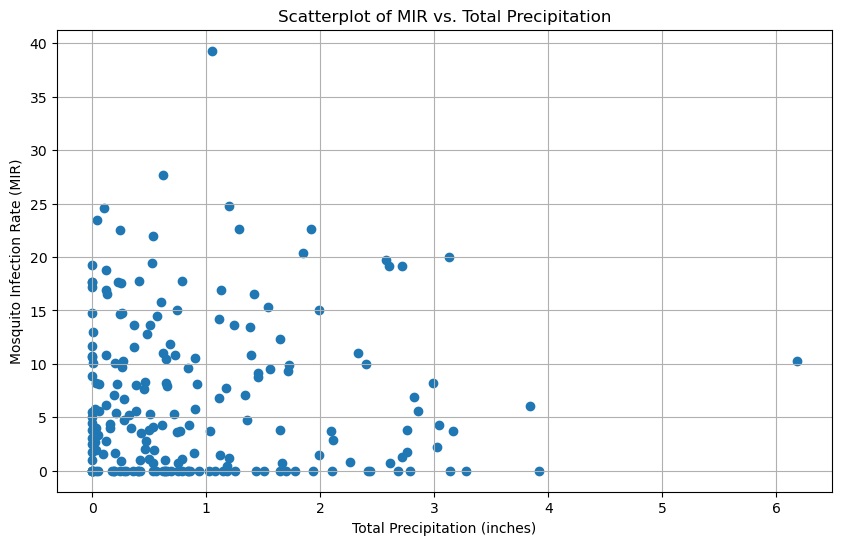

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('../data/processed_data/wnv_wx_merged.csv')

# Scatterplot for MIR vs. Avg_TMAX
plt.figure(figsize=(10, 6))
plt.scatter(df['Avg_TMAX'], df['MIR'])
plt.title('Scatterplot of MIR vs. Average Maximum Temperature')
plt.xlabel('Average Maximum Temperature (°F)')
plt.ylabel('Mosquito Infection Rate (MIR)')
plt.grid(True)
plt.show()

# Scatterplot for MIR vs. Total_PRCP
plt.figure(figsize=(10, 6))
plt.scatter(df['Total_PRCP'], df['MIR'])
plt.title('Scatterplot of MIR vs. Total Precipitation')
plt.xlabel('Total Precipitation (inches)')
plt.ylabel('Mosquito Infection Rate (MIR)')
plt.grid(True)
plt.show()


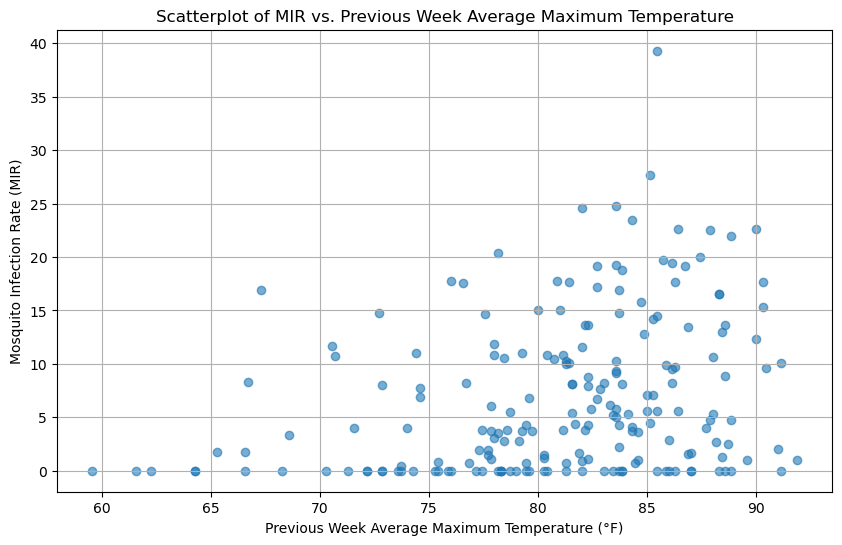

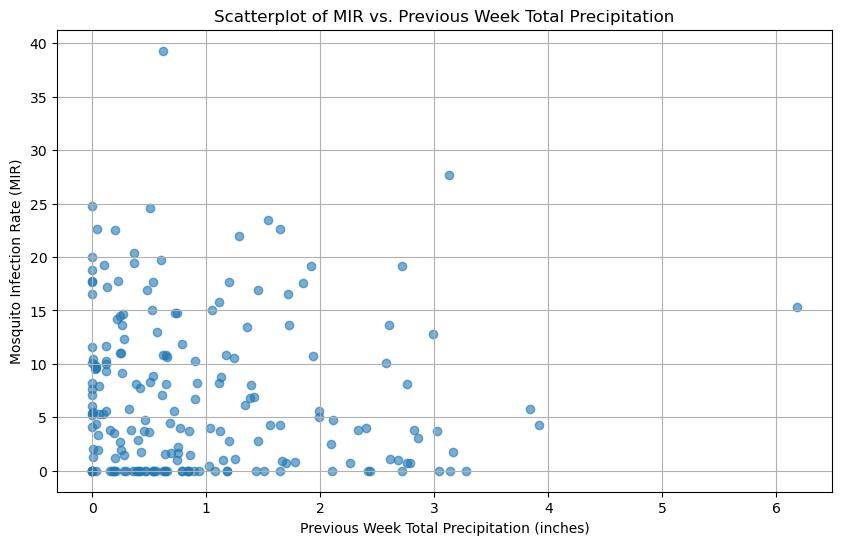

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df_lag = pd.read_csv('../data//processed_data/wnv_wx_merged.csv')  # Replace with your actual path

# Create lagged columns for Avg_TMAX and Total_PRCP
df_lag['Lagged_Avg_TMAX'] = df_lag['Avg_TMAX'].shift(1)
df_lag['Lagged_Total_PRCP'] = df_lag['Total_PRCP'].shift(1)

# Remove the first row as it will now contain NaN values due to the shift
df_lag = df_lag.dropna().reset_index(drop=True)

# Scatterplot for MIR vs. Lagged Avg_TMAX
plt.figure(figsize=(10, 6))
plt.scatter(df['Lagged_Avg_TMAX'], df['MIR'], alpha=0.6)
plt.title('Scatterplot of MIR vs. Previous Week Average Maximum Temperature')
plt.xlabel('Previous Week Average Maximum Temperature (°F)')
plt.ylabel('Mosquito Infection Rate (MIR)')
plt.grid(True)
plt.show()

# Scatterplot for MIR vs. Lagged Total_PRCP
plt.figure(figsize=(10, 6))
plt.scatter(df['Lagged_Total_PRCP'], df['MIR'], alpha=0.6)
plt.title('Scatterplot of MIR vs. Previous Week Total Precipitation')
plt.xlabel('Previous Week Total Precipitation (inches)')
plt.ylabel('Mosquito Infection Rate (MIR)')
plt.grid(True)
plt.show()


In [73]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Load the dataset
df = pd.read_csv('../data//processed_data/wnv_wx_merged.csv')  # Adjust the file path as needed

# Ensure that the MIR is numeric and drop NaN values
df['MIR'] = pd.to_numeric(df['MIR'], errors='coerce')
df = df.dropna()

# The ARIMA model is applied to a time series, so you should ensure that your time series is sorted and has a consistent frequency if possible
# Since we're working with weekly data, we'll assume it's already in the correct order

# Here you need to provide the order (p,d,q) for the ARIMA model, which you can determine experimentally
# For the purpose of this example, let's assume p=1, d=1, q=1, which applies one level of differencing and a simple ARMA(1,1) model
model = ARIMA(df['MIR'], order=(1,1,1))

# Fit the ARIMA model
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                    MIR   No. Observations:                  201
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -601.878
Date:                Wed, 20 Mar 2024   AIC                           1209.757
Time:                        15:22:58   BIC                           1219.652
Sample:                             0   HQIC                          1213.761
                                - 201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0007      1.189     -0.001      1.000      -2.331       2.330
ma.L1         -0.0570      1.193     -0.048      0.962      -2.396       2.282
sigma2        24.0666      1.817     13.248      0.0

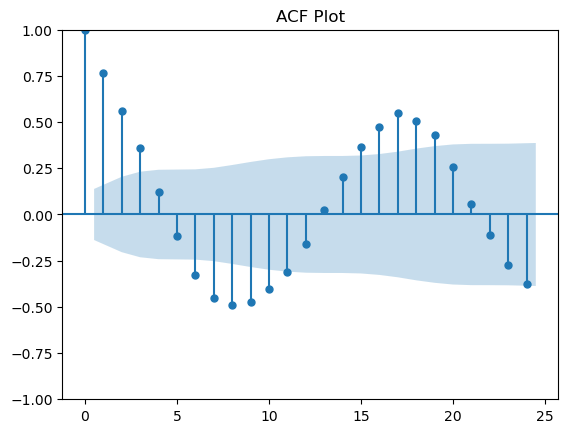

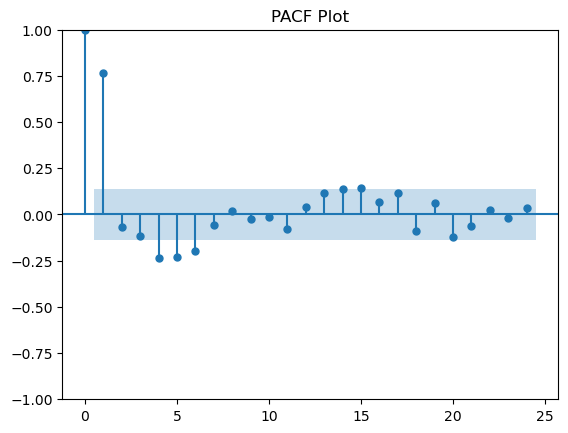

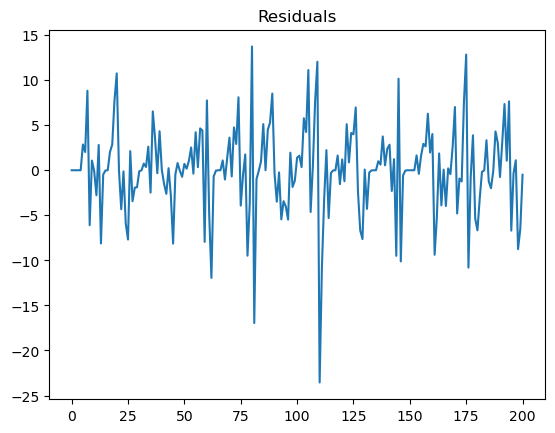

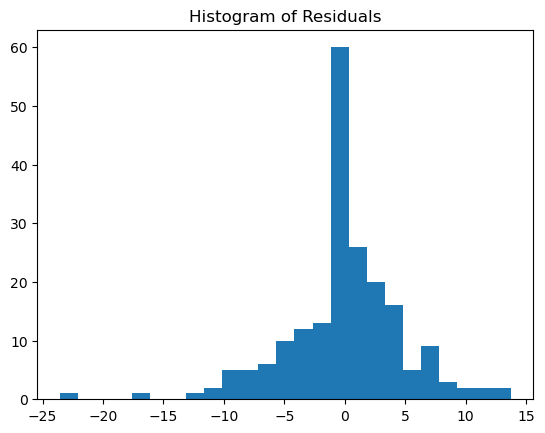

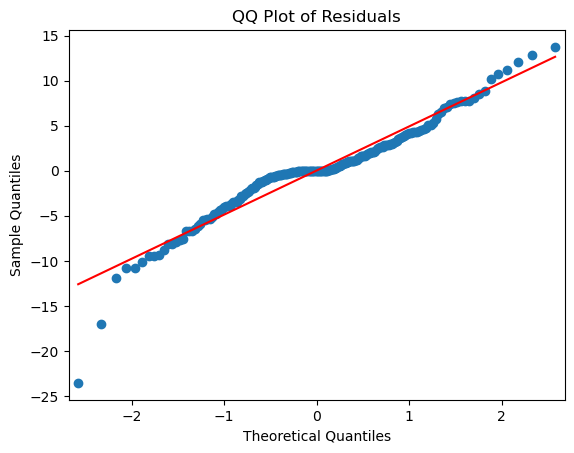

      lb_stat  lb_pvalue
10  28.511907   0.001494


In [81]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'y' is the time series column you're analyzing

# Plot ACF and PACF for model selection
plot_acf(df['MIR'])
plt.title('ACF Plot')
plt.show()

plot_pacf(df['MIR'])
plt.title('PACF Plot')
plt.show()

# Fit an ARIMA model
model = ARIMA(df['MIR'], order=(1,1,1))
model_fit = model.fit()

# Plot residuals
residuals = model_fit.resid
plt.figure()
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Histogram of residuals
plt.figure()
plt.hist(residuals, bins=25)
plt.title('Histogram of Residuals')
plt.show()

# QQ plot of residuals
sm.qqplot(residuals, line='s')
plt.title('QQ Plot of Residuals')
plt.show()

# Optionally, conduct a Ljung-Box test and print the results
ljung_box_result = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_result)


In [95]:
import statsmodels.api as sm
import pandas as pd

# Assuming df_lag has been defined as shown in previous steps

# Create lagged variables
df_lag['Lagged_Avg_TMAX'] = df_lag['Avg_TMAX'].shift(1)
df_lag['Lagged_Total_PRCP'] = df_lag['Total_PRCP'].shift(1)

# Drop the first row to avoid NaN values in lagged columns
df_lag = df_lag.dropna().reset_index(drop=True)

# Add a time index
df_lag['Time_Index'] = df_lag.index

# Prepare the independent variables (predictors) and the dependent variable
X = df_lag[['Lagged_Avg_TMAX', 'Lagged_Total_PRCP', 'Time_Index']]
y = df_lag['MIR']

# Add a constant to the predictors
X = sm.add_constant(X)

# Create and fit the GLM model with a Poisson family and a log link function
model = sm.GLM(y, X, family=sm.families.Poisson(link=sm.genmod.families.links.log()))
result = model.fit()

# Print the summary of the GLM model
print(result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                    MIR   No. Observations:                  199
Model:                            GLM   Df Residuals:                      195
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -984.80
Date:                Wed, 20 Mar 2024   Deviance:                       1405.1
Time:                        15:44:10   Pearson chi2:                 1.35e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5085
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.6099      0.41

/Users/andrewruiz/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


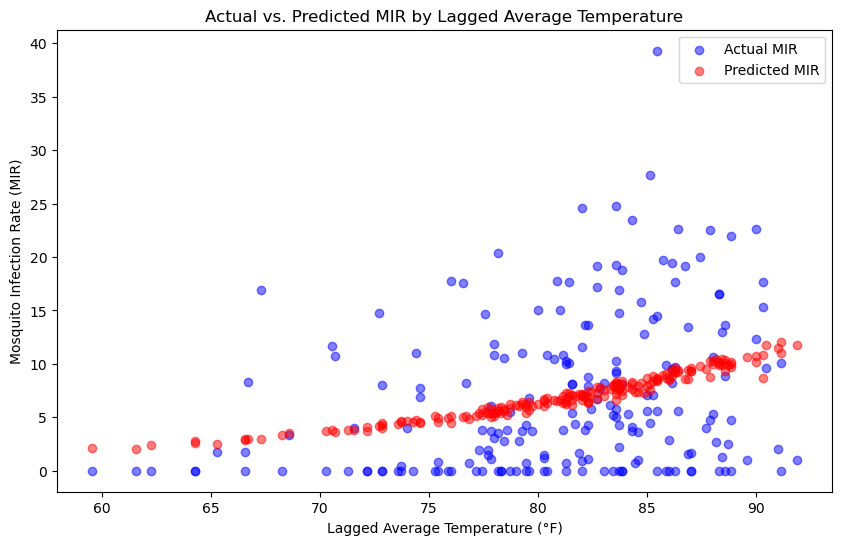

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate predicted MIR from the model
df_lag['Predicted_MIR'] = result.predict(X)

# Plot actual vs. predicted MIR for Lagged_Avg_TMAX
plt.figure(figsize=(10, 6))
plt.scatter(df_lag['Lagged_Avg_TMAX'], df_lag['MIR'], color='blue', label='Actual MIR', alpha=0.5)
plt.scatter(df_lag['Lagged_Avg_TMAX'], df_lag['Predicted_MIR'], color='red', label='Predicted MIR', alpha=0.5)
plt.xlabel('Lagged Average Temperature (°F)')
plt.ylabel('Mosquito Infection Rate (MIR)')
plt.title('Actual vs. Predicted MIR by Lagged Average Temperature')
plt.legend()
plt.show()


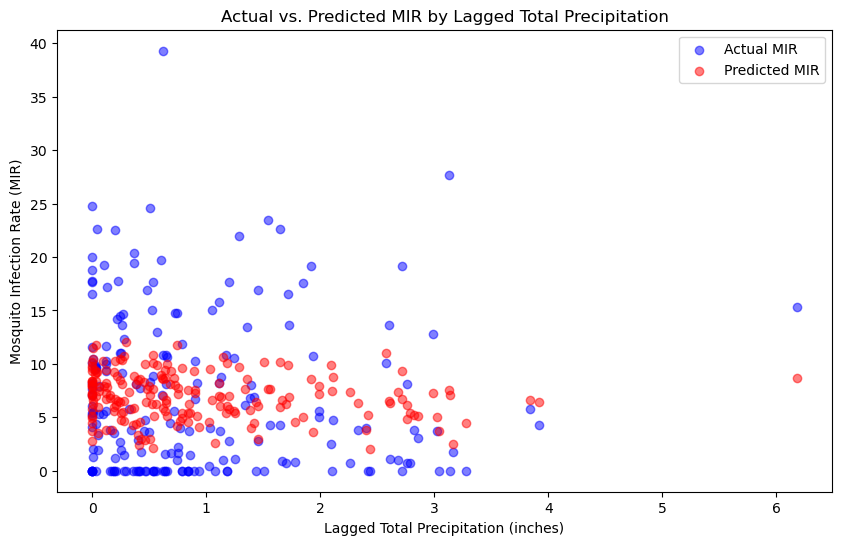

In [99]:
plt.figure(figsize=(10, 6))
plt.scatter(df_lag['Lagged_Total_PRCP'], df_lag['MIR'], color='blue', label='Actual MIR', alpha=0.5)
plt.scatter(df_lag['Lagged_Total_PRCP'], df_lag['Predicted_MIR'], color='red', label='Predicted MIR', alpha=0.5)
plt.xlabel('Lagged Total Precipitation (inches)')
plt.ylabel('Mosquito Infection Rate (MIR)')
plt.title('Actual vs. Predicted MIR by Lagged Total Precipitation')
plt.legend()
plt.show()


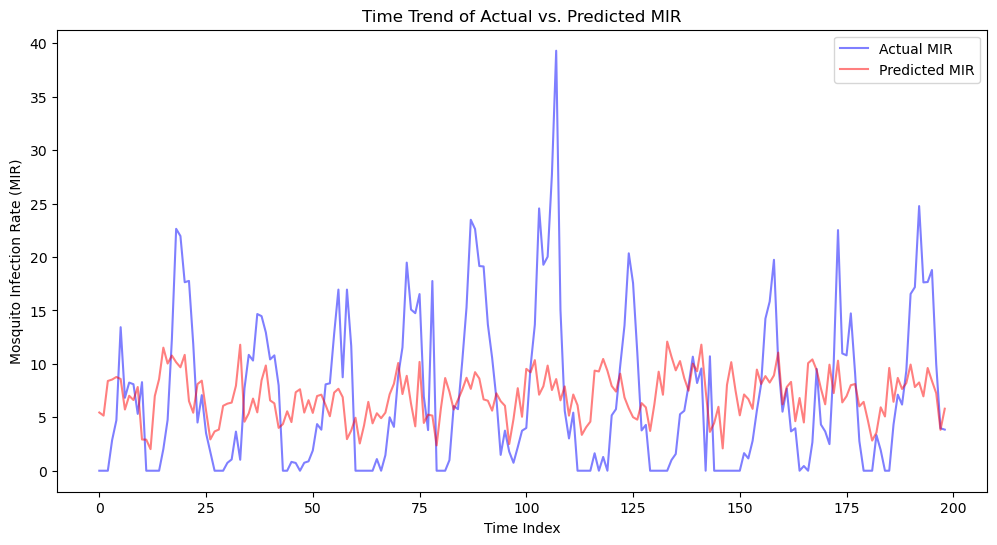

In [101]:
plt.figure(figsize=(12, 6))
plt.plot(df_lag['Time_Index'], df_lag['MIR'], label='Actual MIR', color='blue', alpha=0.5)
plt.plot(df_lag['Time_Index'], df_lag['Predicted_MIR'], label='Predicted MIR', color='red', alpha=0.5)
plt.xlabel('Time Index')
plt.ylabel('Mosquito Infection Rate (MIR)')
plt.title('Time Trend of Actual vs. Predicted MIR')
plt.legend()
plt.show()
